In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from io import StringIO
import matplotlib.dates as dates
from datetime import datetime
import matplotlib.ticker as ticker
from random import shuffle
from time import time
from pandas.plotting import register_matplotlib_converters
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing
import seaborn as sns
#os.chdir('C:\\Users\\A Sua\\Documents\\FIU\\CAP2020')
os.chdir('C:\\Users\\Daniel\\Python and R Notebooks\\CAP2020\\CAP2020')

## Import Data

In [2]:
earnings_path = 'data\\processed\\df_quarter_eps_average_08_09.csv'
training_price_path = 'data\\processed\\df_price07_18.csv'
dividend_path = 'data\\processed\\df_monthly_div_07_18.csv'
key_path = 'data\\external\\quarterly_key_sp_500.csv'
testing_price_path = 'data\\processed\\df_price19.csv'
testing_dividend_path = 'data\\processed\\df_quarter_div_19.csv'
# main metric import

df = pd.read_csv(earnings_path)
df.rename(columns = {'Unnamed: 0':'Stock'}, inplace = True)
df.index = df['Stock']
df.drop('Stock', axis=1, inplace = True)

# import daily price 07-18

df_price = pd.read_csv(training_price_path)
df_price.rename(columns = {'Unnamed: 0':'Stock'}, inplace = True)
new = df_price['Stock'].str.split('_', expand=True)
df_price['symbol'] = new[0]
df_price.index = df_price['symbol']
df_price.drop(['Stock', 'symbol'], axis=1, inplace = True)

# import dividend matrix

df_div = pd.read_csv(dividend_path)
df_div.rename(columns = {'Unnamed: 0':'Stock'}, inplace = True)
df_div.index = df_div['Stock']
df_div.drop('Stock', axis=1, inplace = True)

# import 2019 price

df_price_19 = pd.read_csv(testing_price_path)
df_price_19.rename(columns = {'Unnamed: 0':'Stock'}, inplace = True)
new = df_price_19['Stock'].str.split('_', expand=True)
df_price_19['symbol'] = new[0]
df_price_19.index = df_price_19['symbol']
df_price_19.drop(['Stock', 'symbol'], axis=1, inplace = True)
df_price_19.sort_index(inplace=True)

# import 2019 dividends
df_div_19 = pd.read_csv(testing_dividend_path)
df_div_19.rename(columns = {'Unnamed: 0':'Stock'}, inplace = True)
df_div_19.index = df_div_19['Stock']
df_div_19.drop('Stock', axis=1, inplace = True)
#df_key = pd.read_csv(key_path)
#df_key.index = df_key['symbol']
#df_key.drop(['symbol', 'Unnamed: 2'], axis=1, inplace=True)

## Limit to only SP500 Stocks that traded daily

### For some reason, 2007-2018 has price data that 2019 doesnt. 
### So for now, lets make sure they both have the same number of elements

In [3]:
# define indices
idx_price = df_price.index
idx_price19 = df_price_19.index

# drop stocks
idx_price_diff1 = idx_price.difference(idx_price19)
idx_price_diff2 = idx_price19.difference(idx_price)

df_price.drop(idx_price_diff1, inplace=True)
print('These stocks are missing from 2019 data: {}'.format(idx_price_diff1))

These stocks are missing from 2019 data: Index(['BBT', 'BHI', 'CBS', 'CELG', 'JEC', 'KLAC', 'NEM', 'PIR', 'STI', 'SYMC',
       'VIAB', 'XRX'],
      dtype='object', name='symbol')


### Quarterly data has stocks outside of SP500, have to consider whether its worth it to keep or not

In [4]:
# define indices
idx_price = df_price.index
idx = df.index
idx_div = df_div.index

# drop stocks from metric dataframe

idx_diff1 = idx.difference(idx_price)
df.drop(idx_diff1, inplace=True)
print('df shape: {}'.format(df.shape))

# drop stocks from dividend dataframe

idx_diff2 = idx_div.difference(idx_price)
df_div.drop(idx_diff2, inplace=True)
print('df_div shape: {}'.format(df_div.shape))

### These are only necessary 

df shape: (346, 2)
df_div shape: (346, 108)


## Quick Analysis

In [5]:
# separate stocks into candidates and not candidates

#df['hypothesis']=np.where(abs(df['Recession EPS']-df['Average EPS']) < 0.1, 'Candidate', 'Not Candidate')
#colors = {'Candidate':'red', 'Not Candidate':'blue'}
#df['colors']=df['hypothesis'].apply(lambda x: colors[x])

In [6]:
# sort stocks by difference between average and recession eps
# 20% smallest differences become candidate stocks

ratio = int(round(len(df.index)*0.2))
df['difference'] = abs(df['Recession EPS'] - df['07-18 EPS'])
df.sort_values(by=['difference'], inplace=True)
df['colors'] = ''

df_cand = df.iloc[0:ratio, :]
df_not = df.iloc[ratio:, :]

df_cand['colors'] = 'red'
df_not['colors'] = 'blue'

print('Candidate df shape: {}'.format(df_cand.shape))
print('Not Candidate df shape: {}'.format(df_not.shape))

Candidate df shape: (69, 4)
Not Candidate df shape: (277, 4)


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]


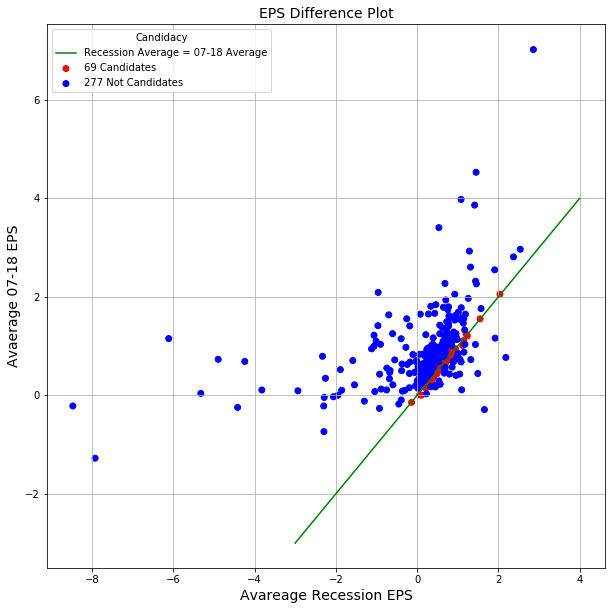

In [7]:
# plot metric decision boundary

sub_title_font =14
legend_font =8
axis_font = 10
x = np.linspace(-3, 4, 100)
y=x

fig, ax = plt.subplots(1, 1, figsize=(10,10))
cand = ax.scatter(df_cand['Recession EPS'], df_cand['07-18 EPS'], c=df_cand.colors, label='{} Candidates'.format(len(df_cand.index)))
not_cand = ax.scatter(df_not['Recession EPS'], df_not['07-18 EPS'], c=df_not.colors, label='{} Not Candidates'.format(len(df_not.index)))
line = ax.plot(x, y, c="green", label='Recession Average = 07-18 Average')

plt.xlabel('Avareage Recession EPS', fontsize=sub_title_font)
plt.ylabel('Avaerage 07-18 EPS', fontsize=sub_title_font)
plt.title('EPS Difference Plot', fontsize=sub_title_font)
ax.tick_params(axis="x", labelsize=axis_font)
ax.tick_params(axis="y", labelsize=axis_font)

plt.grid(which='major')
ax.legend(loc = 'upper left', title='Candidacy')
plt.show()

## Build Portfolio

In [8]:
# take top 30 stocks by EPS

df_cand = df_cand.sort_values(by=['07-18 EPS'], ascending = False)
idx_port = df_cand.head(30).index
print('Portfolio Stocks: {}'.format(idx_port))

# simplify price data to just portfolio stocks

idx_diff3 = idx_price.difference(idx_port)
df_port_price = df_price.drop(idx_diff3)


# simplify dividends data to just portfolio stocks

idx_div2 = df_div.index
idx_diff4 = idx_div2.difference(idx_port)
df_port_div = df_div.drop(idx_diff4)

Portfolio Stocks: Index(['CVX', 'XOM', 'VFC', 'BDX', 'JNJ', 'PG', 'DHR', 'BAX', 'ESS', 'DVA',
       'NKE', 'EW', 'FMC', 'AEP', 'CAH', 'GRMN', 'ADP', 'K', 'PEG', 'EMR',
       'CSX', 'CHD', 'ABC', 'ADM', 'LNT', 'CCL', 'AME', 'KO', 'T', 'EIX'],
      dtype='object', name='Stock')


## Calculate Expected Returns

In [9]:
# annual returns - not enough data points
# list start and end dates for years 2010-2018

#start_dates = ['2010-01-04', '2011-01-03', '2012-01-03', '2013-01-02', '2014-01-02', '2015-01-02', '2016-01-04', '2017-01-03', '2018-01-02']
#end_dates = ['2010-12-31', '2011-12-30', '2012-12-31', '2013-12-31', '2014-12-31', '2015-12-31', '2016-12-30', '2017-12-29', '2018-12-31']

In [10]:
# monthly returns

start_dates = ['2010-01-04', '2010-02-01', '2010-03-01', '2010-04-01', '2010-05-03', '2010-06-01', 
              '2010-07-01', '2010-08-02', '2010-09-01', '2010-10-01', '2010-11-01', '2010-12-01', 
              '2011-01-03', '2011-02-01', '2011-03-01', '2011-04-01', '2011-05-02', '2011-06-01', 
              '2011-07-01', '2011-08-01', '2011-09-01', '2011-10-03', '2011-11-01', '2011-12-01', 
              '2012-01-03', '2012-02-01', '2012-03-01', '2012-04-02', '2012-05-01', '2012-06-01', 
              '2012-07-02', '2012-08-01', '2012-09-04', '2012-10-01', '2012-11-01', '2012-12-03',
              '2013-01-02', '2013-02-01', '2013-03-01', '2013-04-01', '2013-05-01', '2013-06-03', 
              '2013-07-01', '2013-08-01', '2013-09-03', '2013-10-01', '2013-11-01', '2013-12-02', 
              '2014-01-02', '2014-02-03', '2014-03-03', '2014-04-01', '2014-05-01', '2014-06-02', 
              '2014-07-01', '2014-08-01', '2014-09-02', '2013-10-01', '2014-11-03', '2014-12-01', 
              '2015-01-02', '2015-02-02', '2015-03-02', '2015-04-01', '2015-05-01', '2015-06-01',
              '2015-07-01', '2015-08-03', '2015-09-01', '2015-10-01', '2015-11-02', '2015-12-01', 
              '2016-01-04', '2016-02-01', '2016-03-01', '2016-04-01', '2016-05-02', '2016-06-01', 
              '2016-07-01', '2016-08-01', '2016-09-01', '2016-10-03', '2016-11-01', '2016-12-01', 
              '2017-01-03', '2017-02-01', '2017-03-01', '2017-04-03', '2017-05-01', '2017-06-01', 
              '2017-07-03', '2017-08-01', '2017-09-01', '2017-10-02', '2017-11-01', '2017-12-01', 
              '2018-01-02', '2018-02-01', '2018-03-01', '2018-04-02', '2018-05-01', '2018-06-01', 
              '2018-07-02', '2018-08-01', '2018-09-04', '2018-10-01', '2018-11-01', '2018-12-03']

end_dates = ['2010-01-29', '2010-02-26', '2010-03-31', '2010-04-30', '2010-05-28', '2010-06-30', 
            '2010-07-30', '2010-08-31', '2010-09-30', '2010-10-29', '2010-11-30', '2010-12-31', 
            '2011-01-31', '2011-02-28', '2011-03-31', '2011-04-29', '2011-05-31', '2011-06-30', 
            '2011-07-29', '2011-08-31', '2011-09-30', '2011-10-31', '2011-11-30', '2011-12-30', 
            '2012-01-31', '2012-02-29', '2012-03-30', '2012-04-30', '2012-05-31', '2012-06-29', 
            '2012-07-31', '2012-08-31', '2012-09-28', '2012-10-31', '2012-11-30', '2012-12-31', 
            '2013-01-31', '2013-02-28', '2013-03-28', '2013-04-30', '2013-05-31', '2013-06-28', 
            '2013-07-31', '2013-08-30', '2013-09-30', '2013-10-31', '2013-11-29', '2013-12-31', 
            '2014-01-31', '2014-02-28', '2014-03-31', '2014-04-30', '2014-05-30', '2014-06-30', 
            '2014-07-31', '2014-08-29', '2014-09-30', '2014-10-31', '2014-11-28', '2014-12-31', 
            '2015-01-30', '2015-02-27', '2015-03-31', '2015-04-30', '2015-05-29', '2015-06-30', 
            '2015-07-31', '2015-08-31', '2015-09-30', '2015-10-30', '2015-11-30', '2015-12-31', 
            '2016-01-29', '2016-02-29', '2016-03-31', '2016-04-29', '2016-05-31', '2016-06-30', 
            '2016-07-29', '2016-08-31', '2016-09-30', '2016-10-31', '2016-11-30', '2016-12-30', 
            '2017-01-31', '2017-02-28', '2017-03-31', '2017-04-28', '2017-05-31', '2017-06-30', 
            '2017-07-31', '2017-08-31', '2017-09-29', '2017-10-31', '2017-11-30', '2017-12-29', 
            '2018-01-31', '2018-02-28', '2018-03-29', '2018-04-30', '2018-05-31', '2018-06-29', 
            '2018-07-31', '2018-08-31', '2018-09-28', '2018-10-31', '2018-11-30', '2018-12-31']

# function to validate lists above

def list_diff(list1, list2):
    out = [item for item in list1 if not item in list2]
    return out

# validate start dates list

print('Missing Start Dates: {}'.format(list_diff(start_dates, list(df_price.columns))))

# validate end dates list

print('Missing End Dates: {}'.format(list_diff(end_dates, list(df_price.columns))))

Missing Start Dates: []
Missing End Dates: []


In [11]:
# initialize risk free rates for each year
# deannualize from the start of each year

rfr10 = (1+0.0013)**(1/3) - 1
rfr11 = (1+0.0005)**(1/3) - 1
rfr12 = (1+0.0011)**(1/3) - 1
rfr13 = (1+0.00075)**(1/3) - 1
rfr14 = (1+0.0004)**(1/3) - 1
rfr15 = (1+0.0004)**(1/3) - 1
rfr16 = (1+0.0035)**(1/3) - 1
rfr17 = (1+0.0099)**(1/3) - 1
rfr18 = (1+0.0185)**(1/3) - 1

In [12]:
# calculate year end returns

temp_returns = pd.DataFrame(index=idx_port)

for start, end in zip(start_dates, end_dates):
    temp_returns[end] = df_port_price[end] - df_port_price[start]

temp_returns.sort_index(inplace=True)


# export temp returns to fix dividend data in excel

#temp_returns.to_csv('data\\processed\\temp_returns_monthly.csv')


# calculate monthly returns

temp_returns = temp_returns + df_port_div


# calculate percentage returns

df_port_returns = pd.DataFrame(index=idx_port)
df_port_returns.sort_index(inplace=True)

for start, end in zip(start_dates, end_dates):
    df_port_returns[end] = temp_returns[end]/df_port_price[start]


# subtract average yearly risk free rate from each year's returns

df_port_returns.iloc[:, 0:12] = df_port_returns.iloc[:, 0:12] - rfr10
df_port_returns.iloc[:, 12:24] = df_port_returns.iloc[:, 12:24] - rfr11
df_port_returns.iloc[:, 24:36] = df_port_returns.iloc[:, 24:36] - rfr12
df_port_returns.iloc[:, 36:48] = df_port_returns.iloc[:, 36:48] - rfr13
df_port_returns.iloc[:, 48:60] = df_port_returns.iloc[:, 48:60] - rfr14
df_port_returns.iloc[:, 60:72] = df_port_returns.iloc[:, 60:72] - rfr15
df_port_returns.iloc[:, 72:84] = df_port_returns.iloc[:, 72:84] - rfr16
df_port_returns.iloc[:, 84:96] = df_port_returns.iloc[:, 84:96] - rfr17
df_port_returns.iloc[:, 96:108] = df_port_returns.iloc[:, 96:108] - rfr18


# calculate expected monthly returns

df_port = pd.DataFrame(index=idx_port)
df_port.sort_index(inplace=True)
df_port['expected returns'] = df_port_returns.mean(axis=1)

## Calculate Variance of each stock

In [13]:
# putting variance values in returns in df

df_port['variance'] = df_port_returns.var(axis=1)
#df_port

## Calculate Covariance Matrix

### Note: Do a Covariance Heatmap 

In [14]:
# covariance matrix

df_cov = df_port_returns.T.cov()


# check if covariance matrix is invertible
# inverse of covariance matrix

df_cov_inv = pd.DataFrame(np.linalg.inv(df_cov.values), df_cov.columns, df_cov.index)
df_cov_inv.dot(df_cov)

#cov_mat = np.cov(df_port_returns)
#cov_inv = np.linalg.inv(cov_mat)
#cov_mat.dot(cov_inv)

Stock,ABC,ADM,ADP,AEP,AME,BAX,BDX,CAH,CCL,CHD,...,JNJ,K,KO,LNT,NKE,PEG,PG,T,VFC,XOM
Stock,,,,,,,,,,,,,,,,,,,,,
ABC,1.000000e+00,1.290062e-17,8.409976e-16,7.899669e-16,-1.442021e-15,-1.286441e-15,4.495707e-16,-1.867485e-16,-5.899452e-17,8.141936e-16,...,-2.092633e-15,1.148124e-15,-3.794952e-15,-8.627701e-16,-2.763843e-16,-1.156166e-15,-1.514329e-15,1.270385e-16,-1.923737e-15,-2.540977e-15
ADM,-4.887812e-17,1.000000e+00,9.838714e-17,3.947542e-16,8.531154e-16,5.841933e-16,5.816442e-16,-8.897380e-17,-1.338573e-17,7.828782e-16,...,1.099270e-16,5.642366e-16,7.316915e-16,-6.803068e-17,1.956908e-16,2.359232e-17,2.615559e-16,1.058859e-15,-4.387215e-17,1.542860e-18
ADP,-5.640983e-17,-1.150253e-15,1.000000e+00,-1.495096e-15,-9.647271e-16,-2.685935e-16,-3.165536e-16,-5.219192e-16,-1.007790e-15,-2.166641e-15,...,2.600669e-16,-4.483851e-16,5.447677e-16,5.754046e-16,-7.162789e-17,3.595146e-16,-1.679288e-16,4.046079e-16,5.988106e-16,-3.084079e-16
AEP,7.413321e-16,-1.982175e-17,-1.108501e-15,1.000000e+00,1.439682e-15,1.218664e-15,8.620888e-16,-2.125543e-16,-3.893175e-16,-9.005508e-16,...,1.460407e-15,1.542799e-15,2.209713e-15,1.452066e-15,8.288432e-16,1.632320e-15,-2.401750e-16,1.971053e-15,1.662967e-15,1.209067e-15
AME,-3.611901e-16,-6.250840e-16,3.730088e-17,4.936515e-17,1.000000e+00,-2.375948e-16,-3.286088e-16,-4.449125e-16,-3.140400e-16,-1.196587e-16,...,-3.329873e-16,-3.431070e-16,-6.017497e-16,-2.469011e-16,-3.742742e-16,-1.898828e-16,-3.627677e-16,-3.027128e-16,1.014843e-17,-5.245738e-16
BAX,1.769167e-16,4.538417e-16,2.093672e-17,8.192076e-17,2.054542e-16,1.000000e+00,3.480146e-16,1.633491e-16,1.537021e-16,1.203745e-16,...,-3.000738e-17,6.883668e-17,5.867926e-17,3.216485e-16,2.350604e-16,2.703240e-16,1.713885e-16,1.739577e-16,2.309906e-16,2.952798e-16
BDX,-7.146847e-17,-4.194425e-16,5.846623e-18,1.957889e-16,-1.799112e-16,-1.522841e-16,1.000000e+00,1.558168e-16,6.237106e-17,1.267991e-16,...,-4.020596e-16,2.228475e-16,-1.087098e-16,3.767384e-16,-6.621947e-17,-1.261791e-16,-2.834621e-16,-1.716877e-16,-2.059019e-16,6.202924e-17
CAH,3.346457e-16,5.010110e-16,-2.064509e-16,-4.264293e-16,7.887934e-18,-4.157687e-17,-2.120761e-16,1.000000e+00,-2.604556e-16,-4.605680e-16,...,3.774166e-18,1.917534e-16,3.453294e-16,-2.704665e-16,-3.042224e-16,-5.578872e-17,1.019546e-16,7.625305e-16,1.640887e-16,-1.510299e-16
CCL,2.184128e-16,1.464597e-16,-3.233136e-17,-3.737042e-17,3.695959e-17,1.035378e-16,-2.660188e-17,1.654502e-17,1.000000e+00,-6.068824e-17,...,2.554717e-16,1.047702e-16,1.021411e-16,2.688394e-16,1.509484e-16,6.889502e-17,8.883695e-17,3.349810e-16,1.422759e-16,2.583284e-16


Text(0.5, 1, 'Stock Correlation Heatmap')

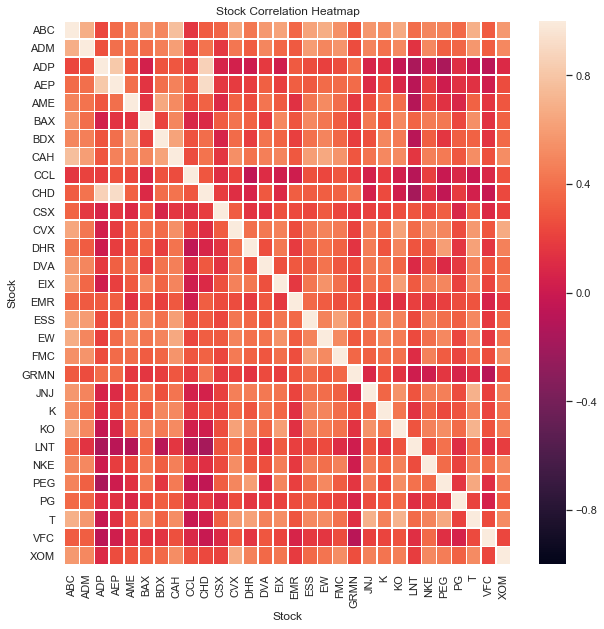

In [15]:
df_corr = df_port_returns.T.corr()
sns.set(rc={'figure.figsize':(10, 10)})
sns.heatmap(df_corr, xticklabels=df_corr.columns, yticklabels=df_corr.columns, linewidths=.5, vmin=-1, vmax=1)
plt.title('Stock Correlation Heatmap')

Text(0.5, 1, 'Stock Covariance Heatmap')

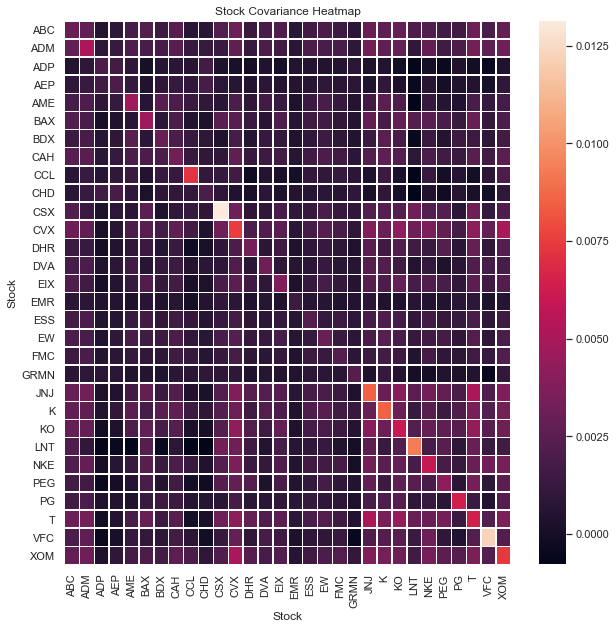

In [16]:
sns.heatmap(df_cov, xticklabels=df_corr.columns, yticklabels=df_corr.columns, linewidths=.5)
plt.title('Stock Covariance Heatmap')

## Calculate Weights

In [17]:
# calculate zeta vector
df_port['zeta'] = df_cov_inv.dot(df_port['expected returns'])


# normalize zeta vector to find weights

zeta_sum = df_port['zeta'].sum()
df_port['weights'] = df_port['zeta']/zeta_sum


# calculate weighted returns
df_port['weighted returns'] = df_port['weights']*df_port['expected returns']

# annualize the expected returns

#df_port['annual returns'] = ((df_port['weighted returns']+1)**12)-1
#df_port['annual returns 2'] = df_port['weighted returns']*np.sqrt(12)
df_port

,expected returns,variance,zeta,weights,weighted returns
Stock,,,,,
ABC,0.012256,0.003013,-3.295251,-0.340733,-0.004176
ADM,0.026243,0.005196,7.090470,0.733164,0.019240
ADP,0.010677,0.002037,0.124325,0.012855,0.000137
AEP,0.012814,0.002040,8.510035,0.879949,0.011276
AME,0.011718,0.004759,-2.932963,-0.303272,-0.003554
BAX,0.012548,0.004735,1.998721,0.206670,0.002593
BDX,0.015055,0.002964,6.792806,0.702385,0.010575
CAH,0.011494,0.003215,-5.753642,-0.594934,-0.006838
CCL,0.006953,0.007189,-2.078019,-0.214870,-0.001494


## Training Data Evaluation

In [18]:
# excess return of portfolio

portfolio_return = df_port['weighted returns'].sum()
print('The Excess Return of the Portfolio: {}'.format(portfolio_return))


# risk of portfolio

weights = df_port['weights']
variance = weights.T.dot(df_cov).dot(weights)
portfolio_risk = np.sqrt(variance)
print('The Risk of the Portfolio: {}'.format(portfolio_risk))


# The Sharpe Ratio

daily_sharpe = portfolio_return/portfolio_risk
print('Monthly Sharpe Ratio: {} month^(-1/2)'.format(daily_sharpe))


# The Annualized Sharpe Ratio

annual_sharpe = daily_sharpe*np.sqrt(12)
print('Predicted Annual Sharpe Ratio: {} year^(-1/2)'.format(annual_sharpe))

The Excess Return of the Portfolio: 0.0544158291527127
The Risk of the Portfolio: 0.07501113680717583
Monthly Sharpe Ratio: 0.7254366680589633 month^(-1/2)
Predicted Annual Sharpe Ratio: 2.512986333503206 year^(-1/2)


In [19]:
#df_cov.to_csv('data\\testing\\covariance_matrix.csv')
#df_port['excess returns'].to_csv('data\\testing\\returns.csv')

## Testing Portfolio on 2019 data

In [20]:
# 2019 rfr
rfr19 = 0.0242

# build 2019 portfolio

df_port_19 = pd.DataFrame(index = idx_port, data=df_port['weights'])
df_port_19['annual returns'] = (df_price_19['2019-12-31'] - df_price_19['2019-01-02'])
df_port_div_19 = df_div_19.loc[idx_port,  'Annual Dividend Estimate']
df_port_19['annual dividends'] = df_port_div_19
df_port_19['total returns'] = (df_port_19['annual returns'] + df_port_19['annual dividends'])/df_price_19['2019-01-02'] - rfr19
df_port_19['weighted returns'] = df_port_19['weights'].multiply(df_port_19['total returns'])
df_port_19['variance'] = df_port['variance']*12
df_port_19

,weights,annual returns,annual dividends,total returns,weighted returns,variance
Stock,,,,,,
CVX,0.515795,9.82000,4.7600,0.107519,0.055458,0.089928
XOM,0.233727,0.09000,3.4300,0.026309,0.006149,0.088767
VFC,0.062699,28.31000,2.0400,0.401168,0.025153,0.146983
BDX,0.702385,51.89000,3.0800,0.225573,0.158439,0.035566
JNJ,0.046427,18.12000,3.7500,0.146994,0.006824,0.102237
PG,-0.145939,33.62000,2.8800,0.375669,-0.054825,0.076887
DHR,0.368774,52.98000,0.6400,0.509332,0.187829,0.039586
BAX,0.206670,18.32000,0.8500,0.269368,0.055670,0.056823
ESS,1.354259,64.26999,7.8000,0.280420,0.379761,0.026356


In [21]:
# 2019 portfolio returns
portfolio_19_returns = df_port_19['weighted returns'].sum()
print('The 2019 Predicted Excess Returns of the Portfolio: {}'.format(portfolio_19_returns))


# 2019 portfolio risk
portfolio_19_risk = portfolio_risk*np.sqrt(12)
print('The 2019 Risk of the Portfolio: {}'.format(portfolio_19_risk))


# 2019 Actual Sharpe Ratio
annual_19_sharpe = portfolio_19_returns/portfolio_19_risk
print('Actual 2019 Sharpe Ratio: {} year^-1/2'.format(annual_19_sharpe))

The 2019 Predicted Excess Returns of the Portfolio: 0.28230660030179056
The 2019 Risk of the Portfolio: 0.25984620016705684
Actual 2019 Sharpe Ratio: 1.0864372852875808 year^-1/2


## Control Portfolio Building

In [22]:
# create control portfolio sample

df_control_price = df_price.sample(n=15, random_state=7)
idx_control = df_control_price.index
df_control_price.sort_index(inplace=True)


# simplify dividends data to just portfolio stocks

idx_diff6 = idx_div2.difference(idx_control)
df_control_div = df_div.drop(idx_diff6)


# calculate year end returns

control_temp_returns = pd.DataFrame(index=idx_control)

for start, end in zip(start_dates, end_dates):
    control_temp_returns[end] = df_control_price[end] - df_control_price[start]

control_temp_returns.sort_index(inplace=True)


# export temp returns to fix dividend data in excel

#temp_returns.to_csv('data\\processed\\temp_returns_monthly.csv')


# calculate monthly returns

control_temp_returns = control_temp_returns + df_control_div


# calculate percentage returns

df_control_returns = pd.DataFrame(index=idx_control)
df_control_returns.sort_index(inplace=True)

for start, end in zip(start_dates, end_dates):
    df_control_returns[end] = control_temp_returns[end]/df_control_price[start]


# subtract average yearly risk free rate from each year's returns

df_control_returns.iloc[:, 0:12] = df_control_returns.iloc[:, 0:12] - rfr10
df_control_returns.iloc[:, 12:24] = df_control_returns.iloc[:, 12:24] - rfr11
df_control_returns.iloc[:, 24:36] = df_control_returns.iloc[:, 24:36] - rfr12
df_control_returns.iloc[:, 36:48] = df_control_returns.iloc[:, 36:48] - rfr13
df_control_returns.iloc[:, 48:60] = df_control_returns.iloc[:, 48:60] - rfr14
df_control_returns.iloc[:, 60:72] = df_control_returns.iloc[:, 60:72] - rfr15
df_control_returns.iloc[:, 72:84] = df_control_returns.iloc[:, 72:84] - rfr16
df_control_returns.iloc[:, 84:96] = df_control_returns.iloc[:, 84:96] - rfr17
df_control_returns.iloc[:, 96:108] = df_control_returns.iloc[:, 96:108] - rfr18


# calculate expected monthly returns

df_control = pd.DataFrame(index=idx_control)
df_control.sort_index(inplace=True)
df_control['expected returns'] = df_control_returns.mean(axis=1)


# putting variance values in returns in df

df_control['variance'] = df_control_returns.var(axis=1)


# covariance matrix

df_control_cov = df_control_returns.T.cov()


# check if covariance matrix is invertible
# inverse of covariance matrix

df_control_cov_inv = pd.DataFrame(np.linalg.inv(df_control_cov.values), df_control_cov.columns, df_control_cov.index)
#df_control_cov_inv.dot(df_control_cov)


# calculate zeta vector
df_control['zeta'] = df_control_cov_inv.dot(df_control['expected returns'])


# normalize zeta vector to find weights

control_zeta_sum = df_control['zeta'].sum()
df_control['weights'] = df_control['zeta']/control_zeta_sum


# calculate weighted returns
df_control['weighted returns'] = df_control['weights']*df_control['expected returns']


# excess return of portfolio

control_return = df_control['weighted returns'].sum()
print('The Excess Return of the Control: {}'.format(control_return))


# risk of portfolio

control_weights = df_control['weights']
control_variance = control_weights.T.dot(df_control_cov).dot(control_weights)
control_risk = np.sqrt(control_variance)
print('The Risk of the Control: {}'.format(control_risk))


# The Sharpe Ratio

control_daily_sharpe = control_return/control_risk
print('Control Monthly Sharpe Ratio: {} month^(-1/2)'.format(control_daily_sharpe))


# The Annualized Sharpe Ratio

control_annual_sharpe = control_daily_sharpe*np.sqrt(12)
print('Predicted Control Annual Sharpe Ratio: {} year^(-1/2)'.format(control_annual_sharpe))

The Excess Return of the Control: 0.042386012499702766
The Risk of the Control: 0.09273588413896156
Control Monthly Sharpe Ratio: 0.45706160989621636 month^(-1/2)
Predicted Control Annual Sharpe Ratio: 1.5833078610589453 year^(-1/2)


## Control Portfolio Evaluating

In [23]:
# build 2019 control

df_control_19 = pd.DataFrame(index = idx_control, data=df_control['weights'])
df_control_19.sort_index(inplace=True)
df_control_19['annual returns'] = (df_price_19['2019-12-31'] - df_price_19['2019-01-02'])
df_control_div_19 = df_div_19.loc[idx_control,  'Annual Dividend Estimate']
df_control_19['annual dividends'] = df_control_div_19
df_control_19['total returns'] = (df_control_19['annual returns'] + df_control_19['annual dividends'])/df_price_19['2019-01-02'] - rfr19
df_control_19['weighted returns'] = df_control_19['weights'].multiply(df_control_19['total returns'])
df_control_19['variance'] = df_control['variance']*12


# 2019 control returns
control_19_returns = df_control_19['weighted returns'].sum()
print('The 2019 Predicted Excess Returns of the Control: {}'.format(control_19_returns))


# 2019 control risk
control_19_risk = control_risk*np.sqrt(12)
print('The 2019 Risk of the Portfolio: {}'.format(control_19_risk))


# 2019 control Actual Sharpe Ratio
control_annual_19_sharpe = control_19_returns/control_19_risk
print('Control Actual 2019 Sharpe Ratio: {} year^-1/2'.format(control_annual_19_sharpe))

The 2019 Predicted Excess Returns of the Control: -0.2764271296155071
The 2019 Risk of the Portfolio: 0.3212465260270044
Control Actual 2019 Sharpe Ratio: -0.8604828604193848 year^-1/2
